# ==============================================================
# Практика 2 по методам оптимизации
### Зуева Надежда, 594 группа
# ==============================================================

# Вам предстоит решать задачу классификации изображений методом логистической регрессии. 

В итоге вы должны получить  функцию $f(x) \to [0,1]^{10}$, которая на вход получает картинку с написанной от руки цифрой, а на выход дает 10 вероятностей от 0 до 1 принадлежности к каждому из классов (цифре). Картинка это вектор из (8*8) = 64 чисел. Мы будем рассматривать параметрическое семейство функций $F(c)$, таких,  что если $f_с \in F$, то она удовлетворяет нашим требованиям. Кроме того, для каждой функции  $f_c \in F$ мы можем посчитать, насколько она хорошо работает на некотором наборе картинок - это будет функционал качества этой функции $loss(f_c, images)$. Чем он меньше, тем лучше: в идеале $loss$ будет давать $0$ в том случае, если наша функция на всех картинках, на которых нарисована цифра $i$ выдала вектор, где все числа отличны от $1$ и только на $i-м$ месте стоит $1$. Иначе это будет некоторое положительное число, которое тем больше, чем хуже работает классификатор (потеря)

Итак, возьмем функцию $g(c) = loss(f_c, images)$ и будем ее минимизировать. Если мы найдем глобальный минимум, то научимся максимально качественно решать задачу классификации с помощью того семейства функций, которое мы выбрали. Глобальный минимум мы, конечно, не сможем аналитически найти, поэтому будем решать задачу минимизации методом градиентного спуска.

# Возьмем датасет нарисованных от руки картинок

In [1]:
import numpy as np 
from numpy import log
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
import math
import math
from sklearn.datasets import load_digits
from sklearn.cross_validation import train_test_split
import tqdm 
import warnings
warnings.simplefilter("ignore")
plt.style.use('fivethirtyeight')
digits = load_digits()

/home/nestyme/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
digits.data.shape

(1797, 64)

# Пример содержимого датасета

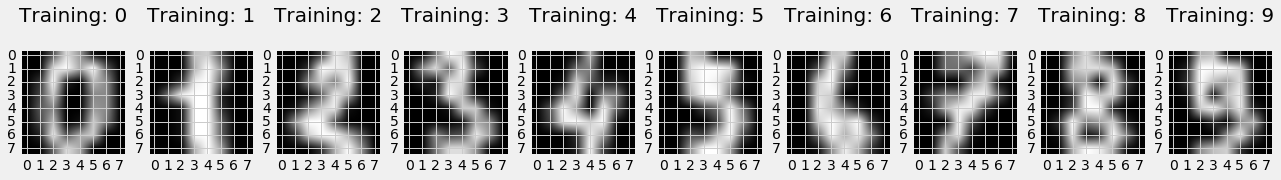

In [3]:
plt.figure(figsize=(20,4))

for index, (image, label) in enumerate(zip(digits.data[0:10], digits.target[0:10])):
    plt.subplot(1, 10, index+1)
    plt.imshow(np.reshape(image, (8,8)), cmap=plt.cm.gray)
    plt.title('Training: %i\n' % label, fontsize = 20)

# Разделим датасет на 2 части - train и validate
1. На первой мы будем решать оптимизационную задачу - искать такую функцию, которая по картинке выдает правильную цифру. 
2. На второй будем независимо проверять, насколько качественно работает наша функция

Это необходимо для того, чтобы понимать, насколько наша функция реально умеет решать поставленную задачу: понимать, где какая цифра. У нас ограниченная выборка - всего 1797 картинок. Но в реальности нарисованных цифр может быть значительно больше! Если даже наша функция безошибочно работает на всех 1797 картинках, но ошибается вне - это плохо. Обычно график обучения должен выглядит примерно так, если зеленое - обучающая выборка, а красное - валидационная

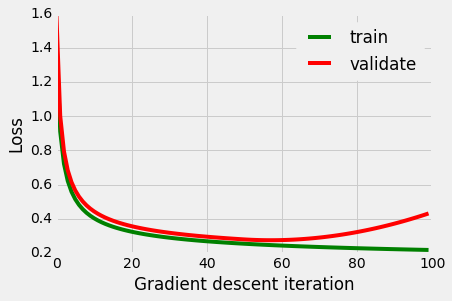

In [4]:
plt.plot(
    [1/math.log(i+2) for i in range(100)], 
    color='green', 
    label='train'
)

plt.plot(
    [1/math.log(i+2)*1.1+( (i/50.0-1)**2./5. if i>50 else 0.) for i in range(100)],
    color='red',
    label='validate')
plt.xlabel('Gradient descent iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

То есть с каждым шагом мы уменьшаем наш loss на обучающей выборке за счет градиентного спуска, но в какой-то момент функция может начать хорошо работать только на обучающей выборке. Этот эффект (в данном примере около 55 итерации по оси x) назвается переобучением.

***Преобразуем числа от 0 до 9 в вектора из 10 элементов, где на i-m месте стоит 1, если цифра равна i и 0 иначе.***

### Также нормализуем картинки: все пиксели - это числа от 0 до 16. Сделаем их от -1 до 1, это улучшит качество нашей модели

In [5]:
def one_hot(y, n_classes):
    tmp = np.zeros(
        (len(y), n_classes), 
        dtype=np.uint8
    )
    tmp[range(len(tmp)), y] = 1
    return tmp

x_train, x_test, y_train, y_test = train_test_split(
    (digits.data-8)/16, 
    one_hot(digits.target,10),
    test_size=0.33, 
    random_state=0
)

## ***Задание***
***Реализовать методом градиентного спуска логистическую регрессию. Начиная с этой ячейки и ниже разрешено использовать только стандартные функции  Python и библиотеки numpy и  matplotlib***

Для каждой картинки мы хотим найти вектор $(p_0,\ldots,p_{10})$, вероятностей, такой, что $p_i$ - вероятность того, что на картинка цифра $i$.

Реализуя логистическую регрессию, мы хотим приближать вероятности к их настоящему распределению. 

Выражение выдает ответ вида 
$$
A x + b
$$


где x - наш вектор картинки, а результат - числовой вектор размерности 10 с какими-то числами. Для того, чтобы эти числа стали вероятностями от 0 до 1, реализуем функцию 
$$
softmax(x) = \frac{e^x}{\sum(e^x)}
$$
и полученные значения будут как раз давать в сумме 1 и ими мы будем приближать вероятности. 

Оценивать качество нашей модели будем с помощью кросс-энтропии, см https://en.wikipedia.org/wiki/Cross_entropy 

In [6]:
def softmax(W,b,x):
    """ 
        во избежание переполнения можем работать с логарифмическим масштабом 
        
    """
    b_log = np.repeat(b, x.shape[1])
    b_log=b_log.reshape(10, x.shape[1])
    return ((np.exp( (W @ x + b_log)).T).T/
            (np.exp( (W @ x + b_log)).T).sum(axis=1)).T
    """ реализуем кросс-энтропию
    """
def loss(y, pred):
    return np.mean((-np.sum(y * log(pred))))

***В данной точке x нужно научиться считать градиент. Выведите правила и посчитайте градиент в точке. Для того, чтобы выбирать градиент по всем точкам, можно его усреднить.***

In [19]:
#todo - расчитать градиент 
def compute_gradients(out, y, x):
    return np.column_stack(((out - y) * x.reshape(-1, 1)).T, out - y)

#усредняем по всем точкам
def gradients(W,b, x,y):
    sm = softmax(W,b,x.T)
    e = [ compute_gradients(a,c,b) for a,c,b in zip(sm,y,x) ]                       
    return np.mean(e,axis=0).T   

***Методом градиентного спуска с постоянным шагом минимизируйте loss на обучающей выборке.***

### ========================================================================================
Рассмотрим W и b --  какие у них должны быть размерности?
На выходе мы должны получить столбец $shape(b)=(10,1)$, $X=(64,1)$ -- по условию.$=>$ $b=M*x$, где $M$ -- некоторая матрица (64,10). 
### ========================================================================================

In [8]:
W = np.zeros((10, 64))
b = np.zeros(10)

losses_train,losses_valid =[], []

for k in tqdm.tqdm(range(5000)):
    
    
    losses_train.append( loss(y_train, softmax(W, b, x_train.T) ) )
    losses_valid.append( loss(y_test, softmax(W, b, x_test.T)) )
    
    
    W -= (gradients(W, b, x_train, y_train).T)[:, :-1]
    b -= (gradients(W, b, x_train, y_train).T)[:, -1]

100%|██████████| 5000/5000 [04:40<00:00, 17.81it/s]


***Нарисуйте графики ошибки (loss) от номера шага градиентного спуска. Как падала ошибка на обучающей и тестовой выборках? На каком шаге ошибка на обучающей выборке оказалась минимальной?***

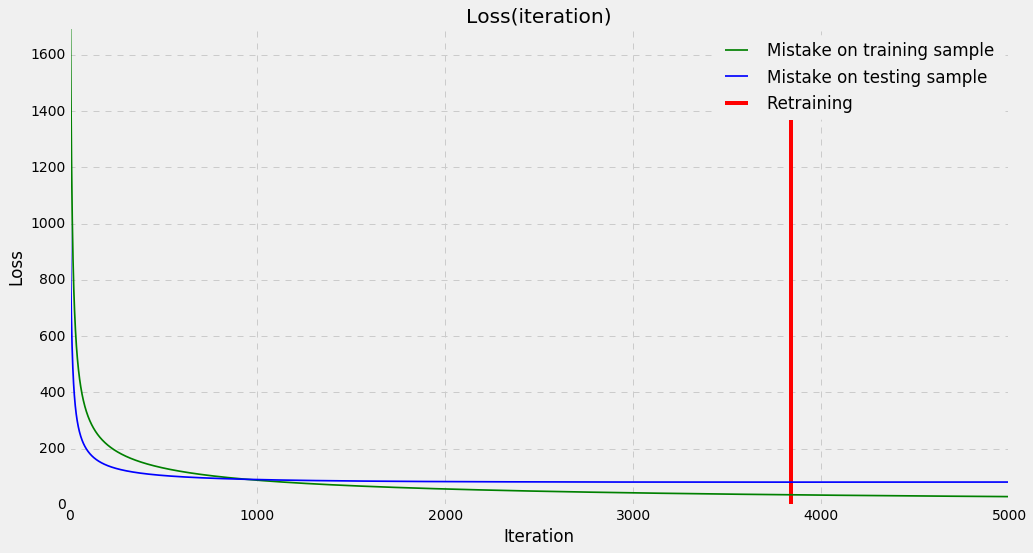

Номер шага с минимальной ошибкой: 3840


In [12]:
print('=======================================================================================================')
plt.figure(figsize=(15, 8))
plt.plot(np.array(losses_train), color = 'g', label='Mistake on training sample', linewidth=1.7)
plt.plot(np.array(losses_valid), color = 'b', label='Mistake on testing sample', linewidth=1.7)
plt.grid(ls="--",linewidth=1)
plt.ylim(0,1700)
plt.title('Loss(iteration)')
plt.xlabel('Iteration')
plt.vlines(np.argmin(losses_valid), color = 'red', ymin = 0, 
           ymax = np.max(losses_valid), label = 'Retraining')
plt.ylabel('Loss')
plt.legend()
plt.show()
print("Номер шага с минимальной ошибкой:", np.argmin(losses_valid))
print('=======================================================================================================')


***Реализуйте выбор шага градиентного спуска методом Армихо. Ускорило ли использование метода Армихо с начальными параметрами
$$ s=100, \beta=\alpha=0.5$$
***достижение минимума на обучающей выборке по сравнению с фиксированным шагом 100? А на валидационной***

In [13]:
def armijo (W, b, x, y, dW, db, alpha=0.5, beta=0.5):
    
    s, sm, k = 100, softmax(W, b, x.T), softmax(W - s * dW, b - s * db, x.T)
    
    grads_w,grads_b  = dW.flatten(),db.flatten()
    
    while (loss(y, k) > loss(y, sm) - s*alpha* np.sum(np.hstack((grads_w, grads_b)) ** 2)):
        s *= beta
        k = softmax(W - s * dW, b - s * db, x.T)
    
    return s


W = np.zeros((10, 64))
b = np.zeros(10)

losses_valid_armijo, losses_train_armijo=[], []

for i in tqdm.tqdm(range(5000)):
    sm = softmax(W, b, x_train.T)
    losses_train_armijo.append(loss(y_train, softmax(W, b, x_train.T)))
    losses_valid_armijo.append(loss(y_test, softmax(W, b, x_test.T)))
    W =W-(gradients(W, b, x_train, y_train).T)[:, :-1]
    b =b-(gradients(W, b, x_train, y_train).T)[:, -1]

100%|██████████| 5000/5000 [04:26<00:00, 18.73it/s]


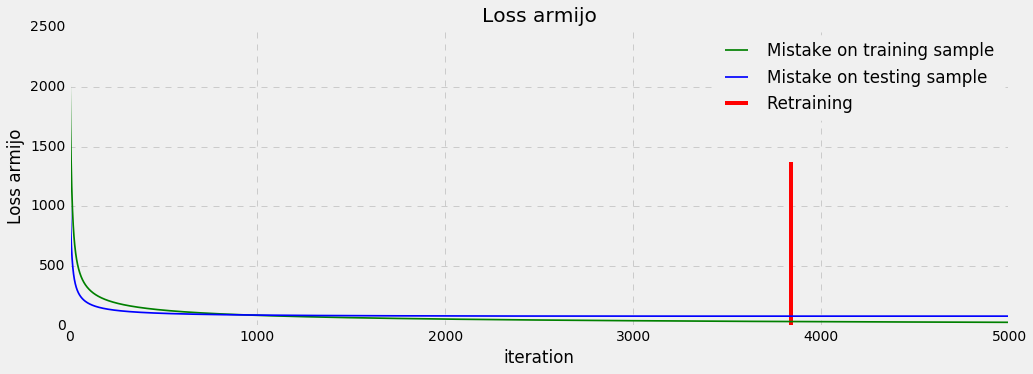

Минимальное значение ошибки достигается на 3840 шаге


In [14]:
print('=======================================================================================================')
plt.figure(figsize=(15, 5))
plt.grid(ls="--",linewidth=1)
plt.ylim(0,2500)
plt.plot(np.array(losses_train_armijo), color = 'g', 
         label='Mistake on training sample', linewidth=1.7)
plt.plot(np.array(losses_valid_armijo), color = 'b', 
         label='Mistake on testing sample', linewidth=1.7)
plt.title('Loss armijo')
plt.xlabel('iteration')
plt.vlines(np.argmin(losses_valid_armijo), color = 'r', ymin = 0, 
           ymax = np.max(losses_valid_armijo), label = 'Retraining')
plt.ylabel('Loss armijo')
plt.legend()
plt.show()
print('=======================================================================================================')
print("Минимальное значение ошибки достигается на",np.argmin(losses_valid_armijo), "шаге")


Точность: 95.45 %
Ошибается на  27 элементах выборки
Работает верно на 567 элементах выборки


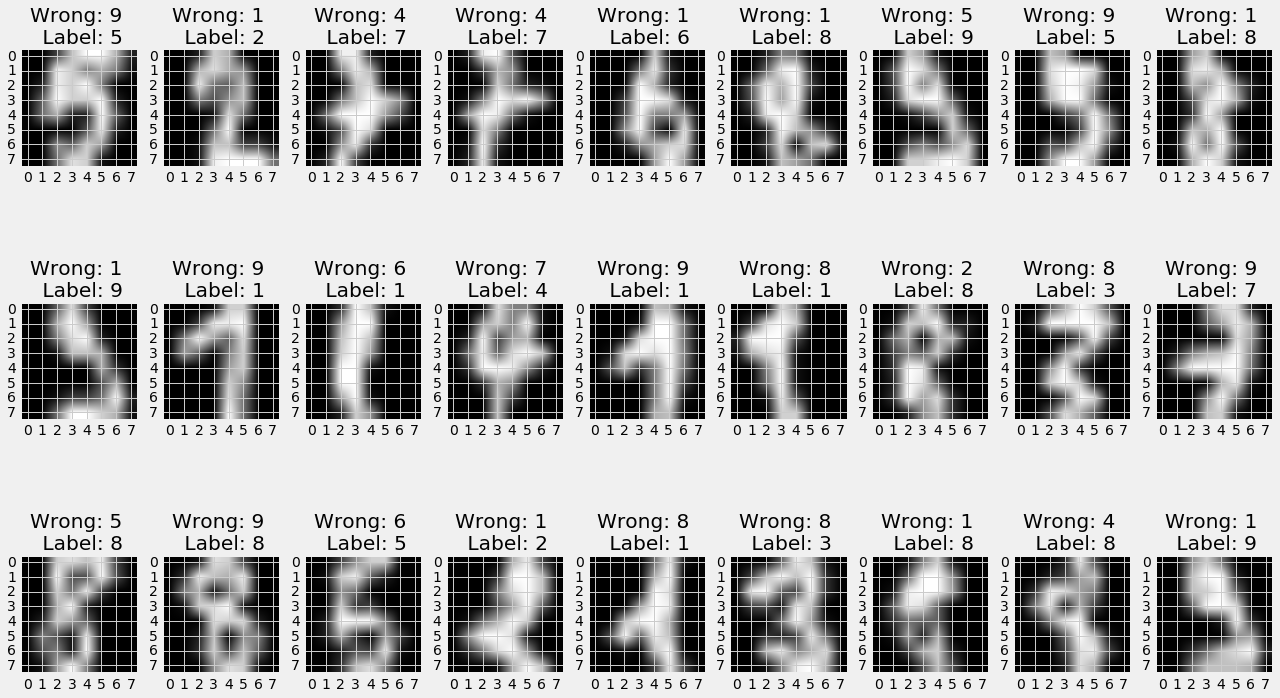

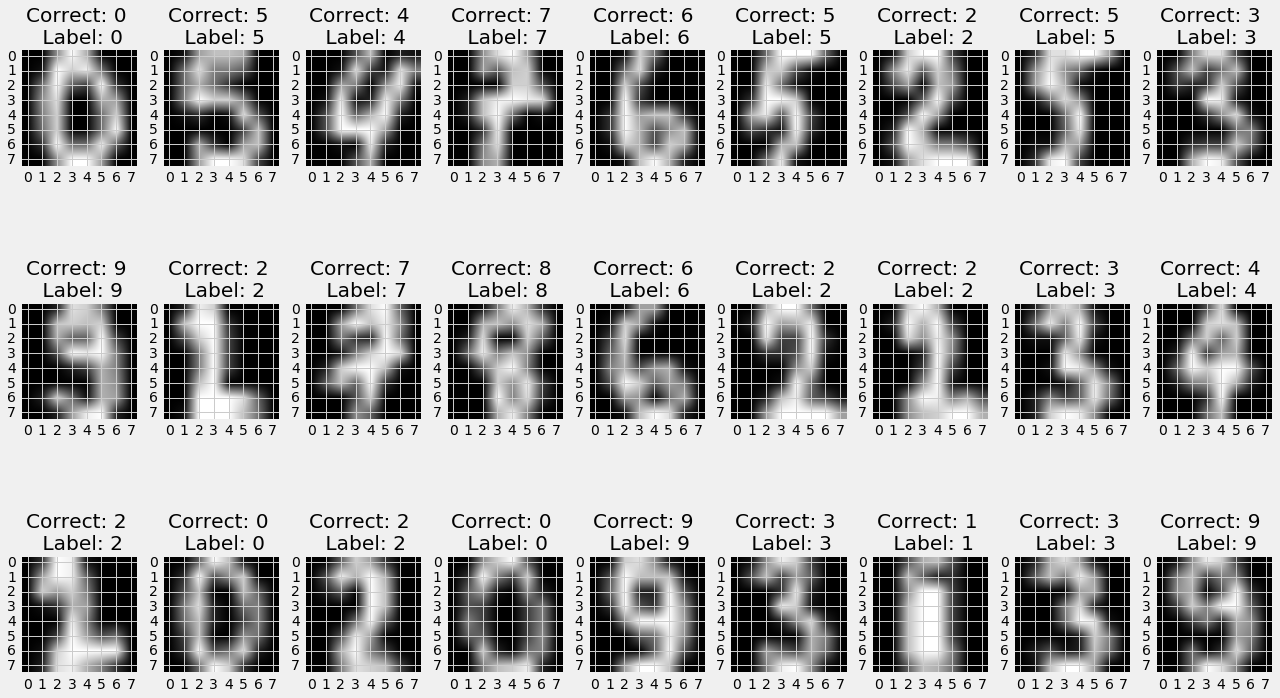

In [18]:
def Incorrect_Recognition():
    y_pred = np.argmax(softmax(W,b,x_test.T), axis=1)
    y_true = []
    for y_t in y_test:
        y_true.append(np.argmax(y_t))
    print("Точность:",round((1 - np.where(y_pred - np.array(y_true))[0].shape[0] / (np.array(y_true)).shape[0])*100,2),"%" )
    print("======================================================================================================")
    lossNum = np.where(y_true - np.array(y_pred))
    print("Ошибается на ",len(lossNum[0]),"элементах выборки")
    
    plt.figure(figsize=(20,12))

    for (idx, error) in enumerate(lossNum[0]):
        if idx == 26:
            pass
        plt.subplot(3, 9, idx+1)
        plt.imshow( np.reshape(x_test[error], (8,8)) , cmap=plt.cm.gray)
        plt.title('Wrong: {} \n Label: {}'.format(y_pred[error], y_true[error]))
Incorrect_Recognition()
print("======================================================================================================")
def Correct_Recognition():
    y_pred = np.argmax(softmax(W,b,x_test.T), axis=1)
    y_true = []
    for y_t in y_test:
        y_true.append(np.argmax(y_t))
    c = np.where((y_true - np.array(y_pred)) == 0)[0]
    print("Работает верно на", len(c), "элементах выборки")
    np.seed = 0
    indices = c[np.random.randint(low=0, high=c.shape[0] - 1, size=27)]
    print("======================================================================================================")
    plt.figure(figsize=(20,12))

    for (idx, good_test) in enumerate(indices):
        plt.subplot(3, 9, idx+1)
        plt.imshow( np.reshape(x_test[good_test], (8,8)) , cmap=plt.cm.gray)
        plt.title('Correct: {} \n Label: {}'.format(y_pred[good_test], y_true[good_test]))
Correct_Recognition()
